In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import StringType
from pyspark.sql.window import Window


# Initialize SparkSession
spark = SparkSession.builder.appName("Data Preprocessing").getOrCreate()

# Reading the CSV file into a PySpark DataFrame
data = spark.read.csv("impure_dataset_final.csv", header=True, inferSchema=True)

# Displaying the first 5 rows
data.show(5)


+---+------+--------+---------+---+----------+--------------------+------------+------------+------------+-----------------+---------+--------+--------+--------+------+------+----------------+--------+
|Age|   Sex|HighChol|CholCheck|BMI|    Smoker|HeartDiseaseorAttack|PhysActivity|      Fruits|     Veggies|HvyAlcoholConsump|  GenHlth|MentHlth|PhysHlth|DiffWalk|Stroke|HighBP|SugarConsumption|Diabetes|
+---+------+--------+---------+---+----------+--------------------+------------+------------+------------+-----------------+---------+--------+--------+--------+------+------+----------------+--------+
|  4|  Male|       0|        1| 26|Non Smoker|                   0|           1|Does not Eat|         Eat|                0|     good|       5|      30|      No|    No|     1|            High|      No|
| 12|  Male|       1|        1| 26|    Smoker|                   0|           0|         Eat|Does not Eat|                0|     good|       0|       0|      No|   Yes|     1|            High|

In [2]:
# Displaying number of rows and columns in the PySpark DataFrame
num_rows = data.count()
num_columns = len(data.columns)

print(f"Number of rows: {num_rows}, Number of columns: {num_columns}")


Number of rows: 70707, Number of columns: 19


In [3]:
# Creating a dictionary to store key information about the dataset
dataset_info = {
    "Number of rows in the dataset are": data.count(), 
    "Number of columns in the dataset are": len(data.columns), 
    "Names of the columns": data.columns  
}

for key, value in dataset_info.items():
    print(f"{key}: {value}")


Number of rows in the dataset are: 70707
Number of columns in the dataset are: 19
Names of the columns: ['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Stroke', 'HighBP', 'SugarConsumption', 'Diabetes']


In [4]:
# Printing summary statistics for numeric columns
data.describe().show()


+-------+------------------+-----+------------------+-------------------+------------------+----------+--------------------+-------------------+------------+------------+-------------------+---------+-----------------+------------------+--------+------+-------------------+----------------+--------+
|summary|               Age|  Sex|          HighChol|          CholCheck|               BMI|    Smoker|HeartDiseaseorAttack|       PhysActivity|      Fruits|     Veggies|  HvyAlcoholConsump|  GenHlth|         MentHlth|          PhysHlth|DiffWalk|Stroke|             HighBP|SugarConsumption|Diabetes|
+-------+------------------+-----+------------------+-------------------+------------------+----------+--------------------+-------------------+------------+------------+-------------------+---------+-----------------+------------------+--------+------+-------------------+----------------+--------+
|  count|             70707|70707|             70707|              70707|             69713|     696

In [5]:
# Step 1: Counting duplicate rows
# Counting the number of rows before removing duplicates
num_rows_before = data.count()

# Counting the number of unique rows (after dropping duplicates)
num_unique_rows = data.dropDuplicates().count()

# Calculating the number of duplicate rows
num_duplicates = num_rows_before - num_unique_rows

# Removing duplicate rows
data = data.dropDuplicates()

# Counting the number of rows after removing duplicates
num_rows_after = data.count()

# Printing the results
print(f"Number of duplicated rows in the dataset: {num_duplicates}")
print(f"Number of rows before removing duplicates: {num_rows_before}")
print(f"Number of rows after removing duplicates: {num_rows_after}")


Number of duplicated rows in the dataset: 5554
Number of rows before removing duplicates: 70707
Number of rows after removing duplicates: 65153


In [6]:
# Step 2: Remove missing values
#Calculate the number of non-null values in each column
non_null_counts = data.select([F.sum(F.when(F.col(column).isNotNull(), 1).otherwise(0)).alias(column) 
                               for column in data.columns])

# Showing the non-null counts per column
non_null_counts.show()

# Calculating the number of null values in each column
null_counts = data.select([F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias(column) 
                           for column in data.columns])

# Showing the null counts per column
null_counts.show()




+-----+-----+--------+---------+-----+------+--------------------+------------+------+-------+-----------------+-------+--------+--------+--------+------+------+----------------+--------+
|  Age|  Sex|HighChol|CholCheck|  BMI|Smoker|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|GenHlth|MentHlth|PhysHlth|DiffWalk|Stroke|HighBP|SugarConsumption|Diabetes|
+-----+-----+--------+---------+-----+------+--------------------+------------+------+-------+-----------------+-------+--------+--------+--------+------+------+----------------+--------+
|65153|65153|   65153|    65153|64166| 64140|               65153|       64957| 64921|  64938|            64221|  64164|   64206|   64189|   64926| 65153| 65153|           65153|   65153|
+-----+-----+--------+---------+-----+------+--------------------+------------+------+-------+-----------------+-------+--------+--------+--------+------+------+----------------+--------+

+---+---+--------+---------+---+------+--------------------

In [7]:
# Calculateing the number of null values for each column
null_counts = data.select([F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias(column) 
                           for column in data.columns])

# Collecting the null counts and find columns with fewer than 300 null values
columns_with_less_than_300_nulls = [column for column in null_counts.columns if null_counts.select(column).first()[0] < 300]

# Dropping rows that have missing values in those columns
data_cleaned = data.dropna(subset=columns_with_less_than_300_nulls)

# Printing the number of rows after removing
print(f"Number of rows after removing rows with missing values in columns with fewer than 300 missing values: {data_cleaned.count()}")


Number of rows after removing rows with missing values in columns with fewer than 300 missing values: 64286


In [8]:
# Step 3: Remove inconsistencies
for column in data.columns:
    # Filtering out 'null' values and then get the distinct unique values
    unique_items = data.filter(F.col(column).isNotNull()).select(column).distinct().collect()
    
    # Converting the result to a list of unique values
    unique_items_list = [row[0] for row in unique_items]
    print(f"Unique items in '{column}':", unique_items_list)


Unique items in 'Age': [-1, -21, 12, -15, 1, 13, 6, 3, -9, -7, -31, 5, -19, 9, 4, 8, 7, 10, -2, -12, 11, 2, -3]
Unique items in 'Sex': ['F', 'Female', 'M', 'Male']
Unique items in 'HighChol': [1, 0]
Unique items in 'CholCheck': [1, 0]
Unique items in 'BMI': ['51', '24.0 kg/m2', '15', '54', '29', '69', '42', '73', '87', '64', '30', '34', '59', '28', '22', '85', '35', '52', '16', '71', '98', '47', '43', '31', '18', '70', '27', '61', '75', '31.0 kg/m2', '17', '26', '46', '77', '89', '68', '60', '19', '41', '23', '55', '95', '38', '40', '38.0 kg/m2', '25', '44', '82', '53', '92', '86', '58', '33.0 kg/m2', '81', '33', '48', '67', '84', '79', '24', '32', '29.0 kg/m2', '20', '56', '36', '37', '49', '63', '65', '39', '25.0 kg/m2', '62', '12', '83', '13', '21', '14', '66', '72', '28.0 kg/m2', '76', '80', '50', '45', '57', '34.0 kg/m2', '21.0 kg/m2', '78', '26.0 kg/m2', '74']
Unique items in 'Smoker': ['Smoker', 'Non Smoker']
Unique items in 'HeartDiseaseorAttack': [1, 0]
Unique items in 'PhysAc

In [9]:
# Replacing values in columns using PySpark
data = data.withColumn('Sex', F.when(F.col('Sex') == 'Male', 'M')
                        .when(F.col('Sex') == 'Female', 'F')
                        .otherwise(F.col('Sex')))

data = data.withColumn('Fruits', F.when(F.col('Fruits') == 'Yes', 'Eat')
                         .when(F.col('Fruits') == 'No', 'Does not Eat')
                         .otherwise(F.col('Fruits')))

data = data.withColumn('Veggies', F.when(F.col('Veggies') == 'Yes', 'Eat')
                         .when(F.col('Veggies') == 'No', 'Does not Eat')
                         .otherwise(F.col('Veggies')))

data = data.withColumn('DiffWalk', F.when(F.col('DiffWalk') == 'Yes', 'Y')
                        .when(F.col('DiffWalk') == 'No', 'N')
                        .otherwise(F.col('DiffWalk')))

data = data.withColumn('Stroke', F.when(F.col('Stroke') == 'Yes', 'Y')
                       .when(F.col('Stroke') == 'No', 'N')
                       .otherwise(F.col('Stroke')))

data = data.withColumn('Diabetes', F.when(F.col('Diabetes') == 'Yes', 'Y')
                        .when(F.col('Diabetes') == 'No', 'N')
                        .otherwise(F.col('Diabetes')))

# Converting 'BMI' column to float after removing ' kg/m2'
data = data.withColumn('BMI', F.regexp_replace('BMI', ' kg/m2', '').cast('float'))

    
    
    # Looping through columns to get unique values in each column using distinct
for column in data.columns:
    # Replacing 'None' or null values with 'Not Specified' before getting distinct values
    unique_items = data.filter(F.col(column).isNotNull()).select(column).distinct().collect()
    
    # Collecting and convert to list
    unique_items_list = [row[0] if row[0] is not None else 'Not Specified' for row in unique_items]
    
    print(f"Unique items in '{column}':", unique_items_list)


Unique items in 'Age': [-1, -21, 12, -15, 1, 13, 6, 3, -9, -7, -31, 5, -19, 9, 4, 8, 7, 10, -2, -12, 11, 2, -3]
Unique items in 'Sex': ['F', 'M']
Unique items in 'HighChol': [1, 0]
Unique items in 'CholCheck': [1, 0]
Unique items in 'BMI': [18.0, 82.0, 64.0, 47.0, 58.0, 39.0, 30.0, 17.0, 26.0, 41.0, 86.0, 29.0, 23.0, 89.0, 67.0, 49.0, 56.0, 14.0, 54.0, 21.0, 55.0, 38.0, 51.0, 48.0, 72.0, 66.0, 70.0, 65.0, 43.0, 27.0, 85.0, 53.0, 87.0, 68.0, 40.0, 12.0, 77.0, 20.0, 57.0, 35.0, 83.0, 34.0, 71.0, 50.0, 76.0, 80.0, 24.0, 69.0, 44.0, 42.0, 16.0, 45.0, 62.0, 46.0, 52.0, 22.0, 81.0, 95.0, 98.0, 59.0, 32.0, 19.0, 25.0, 84.0, 36.0, 33.0, 79.0, 15.0, 92.0, 73.0, 31.0, 63.0, 28.0, 60.0, 61.0, 37.0, 75.0, 13.0, 78.0, 74.0]
Unique items in 'Smoker': ['Smoker', 'Non Smoker']
Unique items in 'HeartDiseaseorAttack': [1, 0]
Unique items in 'PhysActivity': [1, 0]
Unique items in 'Fruits': ['Eat', 'Does not Eat']
Unique items in 'Veggies': ['Eat', 'Does not Eat']
Unique items in 'HvyAlcoholConsump': [1, 

In [10]:
# Step 4: Filling null values  with mode and mean
# Defining a function to impute missing values
def impute_nulls(data):
    for column in data.columns:
        # Checking if column has null values
        if data.filter(data[column].isNull()).count() > 0:
            
            # Handling categorical columns (strings) by filling with mode
            if dict(data.dtypes)[column] == 'string':
                # Calculate the mode (most frequent value) for categorical columns
                mode_value = data.groupby(column).count().orderBy(F.desc('count')).first()[0]
                data = data.fillna({column: mode_value})
            
            # Handling numeric columns by filling with mean
            else:
                # Calculating the mean for numeric columns
                mean_value = data.agg({column: 'avg'}).collect()[0][0]
                data = data.fillna({column: mean_value})

    return data

# Applying the function to impute missing values in the dataset
data = impute_nulls(data)

# Verifying if there are any remaining null values
remaining_nulls = data.filter(F.coalesce(*[F.col(col).isNull() for col in data.columns])).count()
print(f"After imputing the null values, the number of nulls in the dataset are: {remaining_nulls}")


After imputing the null values, the number of nulls in the dataset are: 0


In [11]:
# Step 5: Removing negative values in age column
# Checking for negative values in the 'Age' column
negative_age_count = data.filter(data['Age'] < 0).count()
print(f"Number of negative values in the 'Age' column: {negative_age_count}")

# Removing rows with negative values in the 'Age' column
data_cleaned = data.filter(data['Age'] >= 0)

# Printing the number of rows after removing negative values
remaining_rows = data_cleaned.count()
print(f"Number of rows after removing negative values: {remaining_rows}")


Number of negative values in the 'Age' column: 11
Number of rows after removing negative values: 65142


In [12]:
# Step 6: Creating new attribute AgeGroup to classify as kids and teens
# Defining the age bins and labels
age_bins = [0, 10, 100]
age_labels = ['Kid', 'Teen']

# Creating a new column 'Age_Group' based on the age classification
# Using when() to classify 'Age' into 'Kid' or 'Teen'
data = data_cleaned.withColumn('Age_Group', 
                       F.when((data['Age'] >= age_bins[0]) & (data['Age'] < age_bins[1]), age_labels[0])
                       .when((data['Age'] >= age_bins[1]) & (data['Age'] < age_bins[2]), age_labels[1])
                       .otherwise(None))

# Counting the number of 'Kid' and 'Teen' entries in the 'Age_Group' column
age_group_counts = data.groupBy('Age_Group').count().collect()

# Printing the result
for row in age_group_counts:
    print(f"Age Group: {row['Age_Group']}, Count: {row['count']}")



Age Group: Teen, Count: 27510
Age Group: Kid, Count: 37632


In [13]:
# Step 7: Data type conversion for BMI column
data = data.withColumn("BMI", F.col("BMI").cast("int"))
data = data.withColumn("Age", F.col("Age").cast("int"))

data.show(5)


+---+---+--------+---------+---+----------+--------------------+------------+------------+------------+-----------------+---------+--------+--------+--------+------+------+----------------+--------+---------+
|Age|Sex|HighChol|CholCheck|BMI|    Smoker|HeartDiseaseorAttack|PhysActivity|      Fruits|     Veggies|HvyAlcoholConsump|  GenHlth|MentHlth|PhysHlth|DiffWalk|Stroke|HighBP|SugarConsumption|Diabetes|Age_Group|
+---+---+--------+---------+---+----------+--------------------+------------+------------+------------+-----------------+---------+--------+--------+--------+------+------+----------------+--------+---------+
|  3|  F|       0|        1| 39|Non Smoker|                   0|           1|Does not Eat|Does not Eat|                0|     good|       2|       0|       N|     N|     0|            High|       N|      Kid|
|  9|  M|       1|        1| 29|Non Smoker|                   0|           0|         Eat|         Eat|                0|     good|       0|       0|       N|     N

In [14]:
# Step 8: Creating new attribute "BMI_Group"
bmi_bins = [12, 25, 30, 40, 100]
bmi_labels = ['UnderWeight', 'HealthyWeight', 'OverWeight', 'Obese']

# Using when() to categorize BMI
data = data.withColumn(
    "BMI_Group", 
    F.when(F.col("BMI") <= bmi_bins[1], bmi_labels[0])
     .when((F.col("BMI") > bmi_bins[1]) & (F.col("BMI") <= bmi_bins[2]), bmi_labels[1])
     .when((F.col("BMI") > bmi_bins[2]) & (F.col("BMI") <= bmi_bins[3]), bmi_labels[2])
     .otherwise(bmi_labels[3])
)


# Counting the number of records in each BMI group
bmi_group_counts = data.groupBy("BMI_Group").count()
bmi_group_counts.show()


+-------------+-----+
|    BMI_Group|count|
+-------------+-----+
|        Obese| 4966|
|   OverWeight|20834|
|HealthyWeight|22677|
|  UnderWeight|16665|
+-------------+-----+



In [15]:
# Step 9: Label Encoding to convert categorical values into numerical labels
# Identifying categorical columns by checking the data type
categorical_columns = [col_name for col_name, dtype in data.dtypes if dtype == "string"]

# Applying StringIndexer for each categorical column
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Index").fit(data) for col in categorical_columns]

# Transforming the data using each indexer
for indexer in indexers:
    data = indexer.transform(data)


In [16]:
# Dropping the original string columns
data = data.drop(*categorical_columns)

# Verifying the columns in the DataFrame
print("Columns in the DataFrame after dropping original string columns:", data.columns)

data.show(5)


Columns in the DataFrame after dropping original string columns: ['Age', 'HighChol', 'CholCheck', 'BMI', 'HeartDiseaseorAttack', 'PhysActivity', 'HvyAlcoholConsump', 'MentHlth', 'PhysHlth', 'HighBP', 'Sex_Index', 'Smoker_Index', 'Fruits_Index', 'Veggies_Index', 'GenHlth_Index', 'DiffWalk_Index', 'Stroke_Index', 'SugarConsumption_Index', 'Diabetes_Index', 'Age_Group_Index', 'BMI_Group_Index']
+---+--------+---------+---+--------------------+------------+-----------------+--------+--------+------+---------+------------+------------+-------------+-------------+--------------+------------+----------------------+--------------+---------------+---------------+
|Age|HighChol|CholCheck|BMI|HeartDiseaseorAttack|PhysActivity|HvyAlcoholConsump|MentHlth|PhysHlth|HighBP|Sex_Index|Smoker_Index|Fruits_Index|Veggies_Index|GenHlth_Index|DiffWalk_Index|Stroke_Index|SugarConsumption_Index|Diabetes_Index|Age_Group_Index|BMI_Group_Index|
+---+--------+---------+---+--------------------+------------+-------

In [17]:
# Step 10: Dropping Features
# Count the occurrences of each value in 'SugarConsumption_Index'
sugar_consumption_counts = data.groupBy('SugarConsumption_Index').count().orderBy('SugarConsumption_Index')

# Showing the counts for each label in 'SugarConsumption_Index'
sugar_consumption_counts.show()

# Dropping the 'SugarConsumption_Index' column
data = data.drop('SugarConsumption_Index')


+----------------------+-----+
|SugarConsumption_Index|count|
+----------------------+-----+
|                   0.0|65138|
|                   1.0|    4|
+----------------------+-----+



In [18]:
# Step 11: Removing outliers
# Specifying the columns to clean (BMI and Age)
columns_to_clean = ['BMI', 'Age']

# Calculateing Q1, Q3, and IQR for BMI and Age columns, and filter out outliers
for col_name in columns_to_clean:
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR (Interquartile Range)
    q1 = data.approxQuantile(col_name, [0.25], 0.01)[0]
    q3 = data.approxQuantile(col_name, [0.75], 0.01)[0]
    iqr = q3 - q1
    
    # Defining the lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Printing the bounds for the column
    print(f"Lower bound for '{col_name}': {lower_bound}")
    print(f"Upper bound for '{col_name}': {upper_bound}")
    
    # Filtering out the rows that are outliers for this column
    data = data.filter((F.col(col_name) >= lower_bound) & (F.col(col_name) <= upper_bound))

# Printing the number of rows after removing outliers
print(f"Number of rows after removing outliers: {data.count()}")



Lower bound for 'BMI': 13.0
Upper bound for 'BMI': 45.0
Lower bound for 'Age': 1.0
Upper bound for 'Age': 17.0
Number of rows after removing outliers: 63003


In [19]:
# Step 12: Rolling average of BMI
# Defining a rolling window grouped by BMI_Group_Index and ordered by Age
rolling_window = Window.partitionBy("BMI_Group_Index").orderBy("Age").rowsBetween(-2, 2)

# Adding a column for rolling average of BMI
data = data.withColumn("Rolling_BMI_Avg", F.avg("BMI").over(rolling_window))

# Showing the result with the Rolling_BMI_Avg column
data.select("BMI_Group_Index", "Age", "BMI", "Rolling_BMI_Avg").show(10)


+---------------+---+---+------------------+
|BMI_Group_Index|Age|BMI|   Rolling_BMI_Avg|
+---------------+---+---+------------------+
|            0.0|  1| 26|26.666666666666668|
|            0.0|  1| 26|             26.75|
|            0.0|  1| 28|              26.6|
|            0.0|  1| 27|              26.6|
|            0.0|  1| 26|              26.8|
|            0.0|  1| 26|              26.8|
|            0.0|  1| 27|              27.0|
|            0.0|  1| 28|              27.4|
|            0.0|  1| 28|              27.8|
|            0.0|  1| 28|              27.8|
+---------------+---+---+------------------+
only showing top 10 rows



In [20]:
# Step 13:Grouping by BMI_Group_Index and Calculating the Count
data_grouped = data.groupBy("BMI_Group_Index").agg(F.count("*").alias("count"))

# Defining a window partitioned by BMI_Group_Index and ordered by count descending
ranking_window = Window.orderBy(F.desc("count"))

# Adding the rank column
data_with_rank = data_grouped.withColumn("Rank", F.rank().over(ranking_window))

data_with_rank.show(10)


+---------------+-----+----+
|BMI_Group_Index|count|Rank|
+---------------+-----+----+
|            0.0|22677|   1|
|            1.0|20834|   2|
|            2.0|16664|   3|
|            3.0| 2828|   4|
+---------------+-----+----+



### Machine Learning Algorithms using PySpark's MLlib

In [22]:
import time
execution_times = []
precisions = []
accuracies = []
f1_scores = []
recalls = []

In [23]:
from pyspark.ml.feature import VectorAssembler
# Split the data into train and test
data = data.drop("features")
splits = data.randomSplit([0.8, 0.2], 1234)
train = splits[0]
test = splits[1]

assembler = VectorAssembler(inputCols=['BMI', 'Age', 'HighChol', 'CholCheck', 'PhysActivity', 'HvyAlcoholConsump', 
                                       'HeartDiseaseorAttack', 'MentHlth', 'PhysHlth', 'HighBP', 'Sex_Index', 
                                       'BMI_Group_Index'], outputCol='features')

#### 1. Logistic Regression

In [25]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize Logistic Regression
lr = LogisticRegression(featuresCol='features', labelCol='Diabetes_Index')

# Create a Pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Measure the execution time for fitting the model
start_time = time.time()

# Fit the model
model = pipeline.fit(train)

# Make predictions
predictions_lr = model.transform(test)

# Time taken
end_time = time.time()
execution_time = end_time - start_time

# Compute the confusion matrix
confusion_matrix = predictions_lr.groupBy('Diabetes_Index', 'prediction').count().orderBy('Diabetes_Index', 'prediction')
print("Confusion Matrix:")
confusion_matrix.show()

execution_times.append(execution_time)
print(f"Execution Time: {execution_time} seconds")


Confusion Matrix:
+--------------+----------+-----+
|Diabetes_Index|prediction|count|
+--------------+----------+-----+
|           0.0|       0.0| 4882|
|           0.0|       1.0| 1581|
|           1.0|       0.0| 1944|
|           1.0|       1.0| 4177|
+--------------+----------+-----+

Execution Time: 11.253801584243774 seconds


#### 2. Naive Bayes

In [27]:
from pyspark.ml.classification import NaiveBayes

# Initialize NaiveBayes
nb = NaiveBayes(featuresCol='features', labelCol='Diabetes_Index', modelType="multinomial")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, nb])

# Measure the execution time for fitting the model
start_time = time.time()

# Fit the model
model = pipeline.fit(train)

# Make predictions
predictions_nb = model.transform(test)

# Measure the time it took to fit the model and make predictions
end_time = time.time()
execution_time = end_time - start_time

# Compute the confusion matrix
confusion_matrix = predictions_nb.groupBy('Diabetes_Index', 'prediction').count().orderBy('Diabetes_Index', 'prediction')
print("Confusion Matrix:")
confusion_matrix.show()

execution_times.append(execution_time)
print(f"Execution Time: {execution_time} seconds")

Confusion Matrix:
+--------------+----------+-----+
|Diabetes_Index|prediction|count|
+--------------+----------+-----+
|           0.0|       0.0| 2380|
|           0.0|       1.0| 4083|
|           1.0|       0.0| 1254|
|           1.0|       1.0| 4867|
+--------------+----------+-----+

Execution Time: 3.301290988922119 seconds


#### 3. Support Vector Machine

In [29]:
from pyspark.ml.classification import LinearSVC

# Initialize SVM (Linear Support Vector Machine)
svm = LinearSVC(featuresCol='features', labelCol='Diabetes_Index')

# Create a pipeline
pipeline = Pipeline(stages=[assembler, svm])

# Measure the execution time for fitting the model
start_time = time.time()

# Fit the model
model = pipeline.fit(train)

# Make predictions
predictions_svm = model.transform(test)

# Measure the time it took to fit the model and make predictions
end_time = time.time()
execution_time = end_time - start_time


# Compute the confusion matrix
confusion_matrix = predictions_svm.groupBy('Diabetes_Index', 'prediction').count().orderBy('Diabetes_Index', 'prediction')
print("Confusion Matrix:")
confusion_matrix.show()

execution_times.append(execution_time)
print(f"Execution Time: {execution_time} seconds")

Confusion Matrix:
+--------------+----------+-----+
|Diabetes_Index|prediction|count|
+--------------+----------+-----+
|           0.0|       0.0| 4974|
|           0.0|       1.0| 1489|
|           1.0|       0.0| 2120|
|           1.0|       1.0| 4001|
+--------------+----------+-----+

Execution Time: 8.832097053527832 seconds


#### 4. Random Forest Classifier

In [31]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='Diabetes_Index')

# Create a pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Measure the execution time for fitting the model
start_time = time.time()

# Fit the model
model = pipeline.fit(train)

# Make predictions
predictions_rf = model.transform(test)

# Measure the time it took to fit the model and make predictions
end_time = time.time()
execution_time = end_time - start_time

# Compute the confusion matrix
confusion_matrix = predictions_rf.groupBy('Diabetes_Index', 'prediction').count().orderBy('Diabetes_Index', 'prediction')
print("Confusion Matrix:")
confusion_matrix.show()

execution_times.append(execution_time)
print(f"Execution Time: {execution_time} seconds")

Confusion Matrix:
+--------------+----------+-----+
|Diabetes_Index|prediction|count|
+--------------+----------+-----+
|           0.0|       0.0| 5005|
|           0.0|       1.0| 1458|
|           1.0|       0.0| 2124|
|           1.0|       1.0| 3997|
+--------------+----------+-----+

Execution Time: 8.422480821609497 seconds


#### 5. Gradient Boost Classifier

In [33]:
from pyspark.ml.classification import GBTClassifier

# Initialize GBTClassifier
gbt = GBTClassifier(featuresCol='features', labelCol='Diabetes_Index')

# Create a Pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Measure the execution time for fitting the model
start_time = time.time()

# Fit the model
model = pipeline.fit(train)

# Make predictions
predictions_gb = model.transform(test)

# Measure the time it took to fit the model and make predictions
end_time = time.time()
execution_time = end_time - start_time

# Compute the confusion matrix
confusion_matrix = predictions_gb.groupBy('Diabetes_Index', 'prediction').count().orderBy('Diabetes_Index', 'prediction')
print("Confusion Matrix:")
confusion_matrix.show()

execution_times.append(execution_time)
print(f"Execution Time: {execution_time} seconds")

Confusion Matrix:
+--------------+----------+-----+
|Diabetes_Index|prediction|count|
+--------------+----------+-----+
|           0.0|       0.0| 4943|
|           0.0|       1.0| 1520|
|           1.0|       0.0| 2044|
|           1.0|       1.0| 4077|
+--------------+----------+-----+

Execution Time: 11.985657691955566 seconds


#### 6. Decision Tree

In [35]:
from pyspark.ml.classification import DecisionTreeClassifier

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Diabetes_Index')

# Create a pipeline
pipeline = Pipeline(stages=[assembler, dt])

# Measure the execution time for fitting the model
start_time = time.time()

# Fit the model
model = pipeline.fit(train)

# Make predictions
predictions_dt = model.transform(test)

# Measure the time it took to fit the model and make predictions
end_time = time.time()
execution_time = end_time - start_time

# Compute the confusion matrix
confusion_matrix = predictions_dt.groupBy('Diabetes_Index', 'prediction').count().orderBy('Diabetes_Index', 'prediction')
print("Confusion Matrix:")
confusion_matrix.show()

execution_times.append(execution_time)
print(f"Execution Time: {execution_time} seconds")


Confusion Matrix:
+--------------+----------+-----+
|Diabetes_Index|prediction|count|
+--------------+----------+-----+
|           0.0|       0.0| 4880|
|           0.0|       1.0| 1583|
|           1.0|       0.0| 2117|
|           1.0|       1.0| 4004|
+--------------+----------+-----+

Execution Time: 4.208444595336914 seconds


#### 7. Multilayer Perceptron Classifier (MLP)

In [37]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

assembler = VectorAssembler(inputCols=['BMI', 'Age', 'HighChol', 'CholCheck', 'PhysActivity', 'HvyAlcoholConsump', 
                                       'HeartDiseaseorAttack', 'MentHlth', 'PhysHlth', 'HighBP', 'Sex_Index', 
                                       'BMI_Group_Index'],
                            outputCol='features')

# Initialize MLP classifier
mlp = MultilayerPerceptronClassifier(featuresCol='features', labelCol='Diabetes_Index', maxIter=100)

# Define the network architecture (input layer(5 neurons), hidden layers(4 neurons), output layer(2 neurons))
layers = [len(['BMI', 'Age', 'HighChol', 'CholCheck', 'PhysActivity', 'HvyAlcoholConsump', 'HeartDiseaseorAttack', 'MentHlth', 'PhysHlth', 'HighBP', 'Sex_Index', 'BMI_Group_Index']),
          5, 
          4,
          2]

# Set the layers for the MLP model
mlp.setLayers(layers)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, mlp])

# Measure the execution time for fitting the model
start_time = time.time() 

# Fit the model
model = pipeline.fit(train)

# Make predictions
predictions_mlp = model.transform(test)

# Measure the time it took to fit the model and make predictions
end_time = time.time()
execution_time = end_time - start_time

# Compute the confusion matrix
confusion_matrix = predictions_mlp.groupBy('Diabetes_Index', 'prediction').count().orderBy('Diabetes_Index', 'prediction')

# Show the confusion matrix
print("Confusion Matrix:")
confusion_matrix.show()

execution_times.append(execution_time)
print(f"Execution Time: {execution_time} seconds")


Confusion Matrix:
+--------------+----------+-----+
|Diabetes_Index|prediction|count|
+--------------+----------+-----+
|           0.0|       0.0| 4981|
|           0.0|       1.0| 1482|
|           1.0|       0.0| 2079|
|           1.0|       1.0| 4042|
+--------------+----------+-----+

Execution Time: 16.55525302886963 seconds


### Model Evaluation

In [39]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Initialize evaluators
binary_evaluator = BinaryClassificationEvaluator(labelCol='Diabetes_Index')
precision_evaluator = MulticlassClassificationEvaluator(labelCol='Diabetes_Index', predictionCol='prediction', metricName='weightedPrecision')
recall_evaluator = MulticlassClassificationEvaluator(labelCol='Diabetes_Index', predictionCol='prediction', metricName='weightedRecall')
f1_evaluator = MulticlassClassificationEvaluator(labelCol='Diabetes_Index', predictionCol='prediction', metricName='f1')

accuracies = []
precisions = []
recalls = []
f1_scores = []

# List of models and their predictions
models_predictions = [
    ('Logistic Regression', predictions_lr),
    ('Naive Bayes', predictions_nb),
    ('SVM', predictions_svm),
    ('Random Forest', predictions_rf),
    ('Gradient Boost', predictions_gb),
    ('Decision Tree', predictions_dt),
    ('MLP', predictions_mlp)
]

# Define a function to evaluate each model
def evaluate_model(predictions):
    accuracy = binary_evaluator.evaluate(predictions)
    precision = precision_evaluator.evaluate(predictions)
    recall = recall_evaluator.evaluate(predictions)
    f1_score = f1_evaluator.evaluate(predictions)
    
    return accuracy, precision, recall, f1_score

# Loop through each model and compute metrics
for model_name, predictions in models_predictions:
    accuracy, precision, recall, f1_score = evaluate_model(predictions)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

print(f"F1 Scores: {f1_scores}")
print(f"Precisions: {precisions}")
print(f"Recalls: {recalls}")


F1 Scores: [0.7194282773000713, 0.5562811385737868, 0.7120886412817475, 0.7141383227528244, 0.7159677760781009, 0.7051030707432226, 0.7160142641556073]
Precisions: [0.7201771672164339, 0.6008723594262904, 0.7145923832010488, 0.716975503951605, 0.717656379551135, 0.7067915215172701, 0.7182641977776669]
Recalls: [0.7198823903369358, 0.5758900190718372, 0.7132072472981563, 0.7153528289891926, 0.7167832167832167, 0.7059758423394786, 0.7170216147488875]


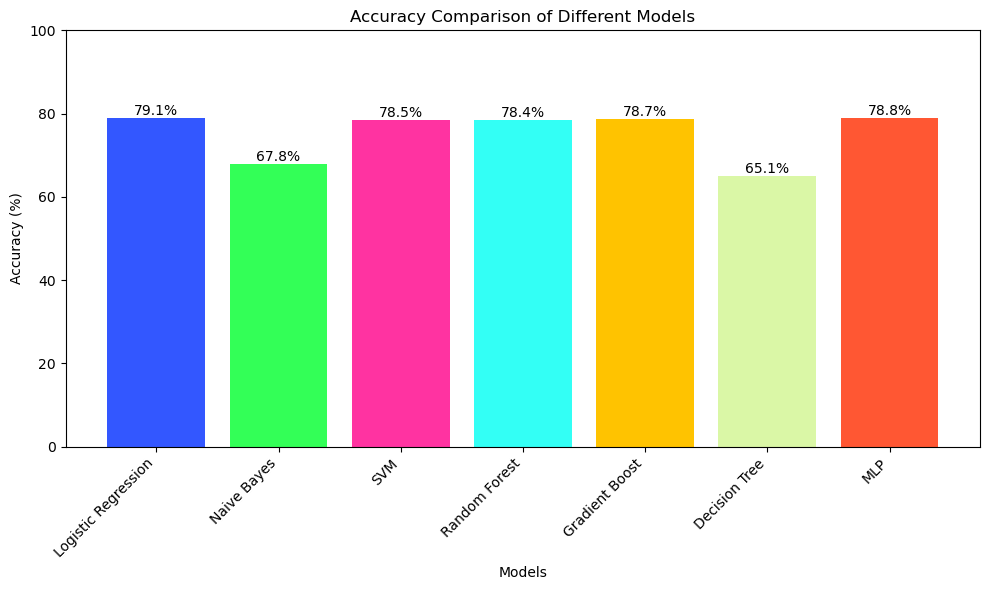

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest', 'Gradient Boost', 'Decision Tree', 'MLP']

# Colors for each model, same as phase 2
colors = ['#3357FF', '#33FF57', '#FF33A1', '#33FFF5', '#FFC300', '#DAF7A6', '#FF5733']
model_scores = [score * 100 for score in accuracies]

# Create a bar plot for accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(models, model_scores, color=colors)
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Different Models')
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 100)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.1f}%',ha='center', va='bottom')
plt.tight_layout()
plt.show()


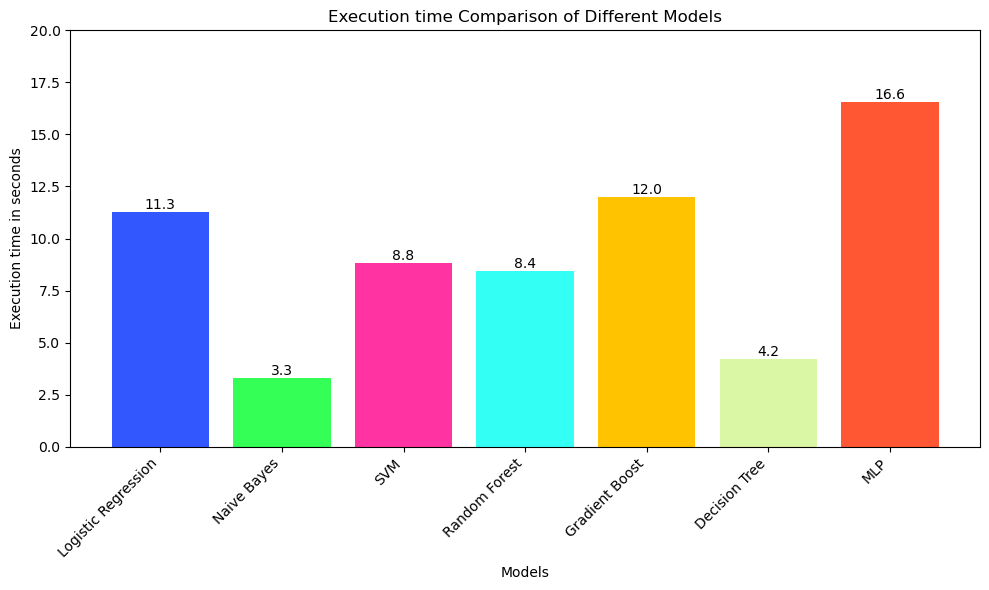

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest', 'Gradient Boost', 'Decision Tree', 'MLP']

# Colors for each model, same as phase 2
colors = ['#3357FF', '#33FF57', '#FF33A1', '#33FFF5', '#FFC300', '#DAF7A6', '#FF5733']

# Create a bar plot for accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(models, execution_times, color=colors)
plt.xlabel('Models')
plt.ylabel('Execution time in seconds')
plt.title('Execution time Comparison of Different Models')
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 20)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.1f}',
             ha='center', va='bottom')
plt.tight_layout()
plt.show()


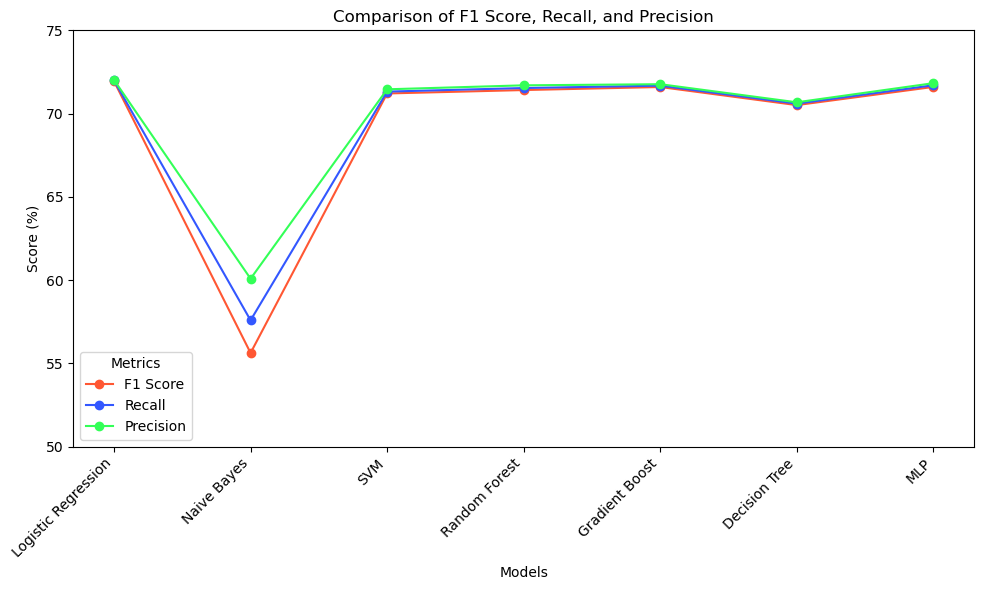

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Models and their performance metrics
models = ['Logistic Regression', 'Naive Bayes', 'SVM', 'Random Forest', 'Gradient Boost', 'Decision Tree', 'MLP']

# Ensure the metrics are multiplied by 100 for percentage representation
f1_scores_100 = [score * 100 for score in f1_scores]
recalls_100 = [score * 100 for score in recalls]
precisions_100 = [score * 100 for score in precisions]

# Create a line chart for F1 Score, Recall, and Precision
plt.figure(figsize=(10, 6))

# Plot the metrics
colors = ['#FF5733', '#33FF57', '#3357FF']
plt.plot(models, f1_scores_100, marker='o', label='F1 Score', color=colors[0])
plt.plot(models, recalls_100, marker='o', label='Recall', color=colors[2])
plt.plot(models, precisions_100, marker='o', label='Precision', color=colors[1])
plt.xlabel('Models')
plt.ylabel('Score (%)')
plt.title('Comparison of F1 Score, Recall, and Precision')
plt.ylim(50, 75)
plt.legend(title='Metrics')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
